# AGRIS Authors disambiguating project

# A. Project Overview

## A.1 Background

Despite the great variety of names and surnames that exists in the world, it is not a strange thing that two persons have exactly the same full name. This can be a problem in some cases because something can be attributed to one person when it is not the author. Moreover, the problem increases when the full name is not present in the attribution but only an abbreviation of it (e.g. R. Smith).

In [1]:
import pyspark
import os
import math
import random
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import re

# make sure pyspark tells workers to use python2 not 3 if both are installed\\n\",\n",
os.environ["PYSPARK_PYTHON"] = "python2"
os.environ['PYSPARK_SUBMIT_ARGS'] = ('--packages '
    'graphframes:graphframes:0.3.0-spark2.0-s_2.11'
    ' pyspark-shell')
os.environ['PYTHONPATH'] = ':'.join(sys.path)

from pyspark.sql import SQLContext
from pyspark import SparkContext, SparkConf

sc = pyspark.SparkContext('local[*]')
sqlContext = SQLContext(sc)

reload(sys)
sys.setdefaultencoding('utf-8')

import matplotlib.pyplot as plt
from pyspark.mllib.regression import LabeledPoint
import csv
import itertools
from graphframes import *
import toyplot

In [13]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg.distributed import MatrixEntry
from pyspark.mllib.linalg.distributed import CoordinateMatrix
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.feature import HashingTF
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import col
from difflib import SequenceMatcher
from graphframes import *
import toyplot

In [2]:
!pip install toyplot

In [3]:
top13 = sc.textFile("data/top13USACommonFullNames2011.csv")
top13 = top13.map(lambda x: x.split(";"))
top13Names = top13.map(lambda x : x[0])
top13Values = top13.map(lambda x : int(x[1].replace(",",'')))
top13Values = [x for x in top13Values.toLocalIterator()]
top13Names = [x for x in top13Names.toLocalIterator()]

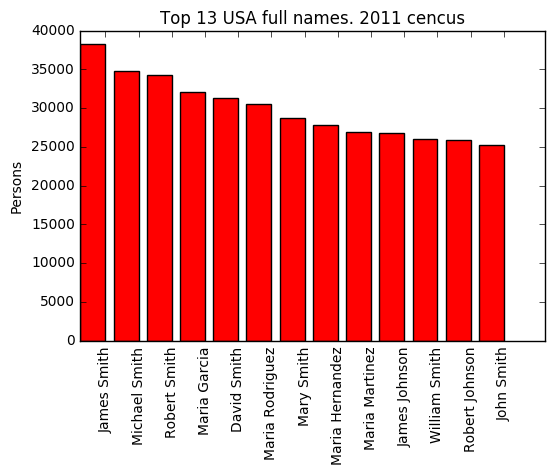

In [4]:
ind = np.arange(top13.count())
width = 0.75

fig, ax = plt.subplots()
rects1 = ax.bar(ind, top13Values, width, color='r')

ax.set_ylabel('Persons')
ax.set_title('Top 13 USA full names. 2011 cencus')
ax.set_xticks(ind + width)
ax.set_xticklabels(top13Names, rotation='vertical')

## A.2 Business problem

One of the areas where this problem occurs is in scientific publications. Researchers around the world are publishing articles under his abbreviated name. It results in lots of articles signed with the same name which corresponds to different persons. Particularly, this happens in the AGRIS repository, which contains a large number of articles focused in Agricultural Science and Technology.

As a researcher with a quite common name, I would not like to have my publications mixed among others to which I have not participated. Moreover, when I search for my articles I do not want to get articles from other persons. 

This is a fact that not only happens on AGRIS repository but on most of the research articles repositories. So finding a way of solving this problem would be well seen by many research organizations. 

In [ ]:
def unicode_csv_reader(unicode_csv_data, dialect=csv.excel, **kwargs):
    # csv.py doesn't do Unicode; encode temporarily as UTF-8:
    csv_reader = csv.reader(utf_8_encoder(unicode_csv_data),
                            dialect=dialect, **kwargs)
    for row in csv_reader:
        # decode UTF-8 back to Unicode, cell by cell:
        yield [unicode(cell, 'utf-8') for cell in row]

def utf_8_encoder(unicode_csv_data):
    for line in unicode_csv_data:
        yield line.encode('utf-8')

In [ ]:
lines = sc.textFile("../2000s_authors.csv")
header = lines.first()
rows = lines.filter(lambda line: line != header)
authors = rows.map(lambda line: list(unicode_csv_reader(line))).filter(lambda x: len(x) == 3).flatMap(lambda x: x[2])
authors.count()

In [ ]:
keyToSearch = 'Ellmerer, E.P.'#'Yamaoka, Y.'#'Zidorn, C.'#'Ellmerer, E.P.'#'Congress.'
filteredAuthors = authors.map(lambda authorsArticle: authorsArticle.split('|'))
filteredAuthors = filteredAuthors.map(set).filter(lambda a: keyToSearch in a).map(lambda a: a.difference({keyToSearch}))
filteredAuthors.count()

## A.3 Objective

The goal of the project is to separate all author names which belongs to different persons. By this way, we could see the articles related to each author name divided by the real person who authored these articles.

In a more technical manner, it would mean that given a dataset with information about different articles (publication year, authors, subjects, journal, …), our project would have to be able to assign a unique identifier to each person and return the same dataset with the corresponding identifier near each author name.


## A.4 Approach

However, doing this work needs a high computational power that we do not have now. So as a first approach we will only distinguish the different persons related with a given name. By this way, in this first approach we will receive a name to disambiguate from the dataset’s articles.

In [ ]:
coauthors = filteredAuthors.flatMap(lambda a: [[tuple(sorted(coauth)), 1] for coauth in itertools.combinations(a, 2)])
coauthorsMap = coauthors.reduceByKey(lambda x, y: x + y)
coauthorsList = coauthorsMap.map(lambda (key,val): (key[0],key[1],val))

In [ ]:
def yieldFunc(list):
    for item in list:
        yield item
coauthorsunique = filteredAuthors.flatMap(yieldFunc).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)

In [ ]:
def toCSVLine(data):
    return ';'.join(str(d) for d in data)

lines = coauthorsunique.map(toCSVLine)
lines.saveAsTextFile("data/coauthorsunique/" + keyToSearch.split(",")[0]);

lines = coauthorsList.map(toCSVLine)
lines.saveAsTextFile("data/coauthorslist/" + keyToSearch.split(",")[0]);

In [ ]:
v = sqlContext.createDataFrame(coauthorsunique,['id','times'])
e = sqlContext.createDataFrame(coauthorsList,['src','dst','times'])
g = GraphFrame(v, e)

In [ ]:
edges_array = np.array(
    g.edges
    .select("src", "dst").rdd
    .map(lambda r: [r.src, r.dst])
    .collect()
)

In [ ]:
toyplot.graph(edges_array, width=1000);

## A.5 Output

As the output of this first approach, we will have different blocks of articles, each one representing the articles of a different person who is represented by the received name. By this way, an author will be easily able to search for his articles in a repository and obtain only the ones made by him. The only steps he will have to do are searching introducing his name and select the block corresponding to him, which will be easily recognised looking at the first articles.


## A.6 Success measures

As measures for the success of the project we will have a verified dataset which we will use to determine the correctness of our results. This verified dataset has been manually verified by some researchers of different spanish universities. So the procedure to test our project will be to apply the disambiguating process to the verified dataset and compare our results with the manually verified results. The difference between both results should be minimal.

## A.7 Activity & timing

We have already started working with the first phase of the execution of the project, which corresponds to the obtaining and cleaning of the data for leaving it ready to be processed without errors and do the disambiguating process. This phase should be finished by the 15th of december. 

The second phase of the project will be to implement the disambiguating process and testing it ensuring the correctness of it. This will be the most difficult phase of the project and thus the longest, this phase should be finished by the 20th of january. 

As the project’s final presentation will be the 1st of february, we will have ten days after finishing the implementation to prepare the final report and presentation.

![title](t.png)

## A.9 Dependencies, assumptions & constraints

In this project we will work with the data from the AGRIS repository. This repository has a sparql endpoint where you can query the data. However, we have tried the sparql endpoint and it is not working very well. To avoid this problem and consequently the dependency with the AGRIS sparql endpoint, we have obtained the full AGRIS dataset and we have loaded it in a local sparql endpoint which is faster and more reliable.

On the other hand, an important assumption of the project is that we will have a manually disambiguated dataset to test our application. We know that this dataset exists and has been manually verified by researchers from Valencia and Basque Country but we do not have it yet. So we will have to contact with this researchers and ask for the verified dataset. Anyway, we hope they will be very pleased to yield their work to improve the authors disambiguating process.

Finally, we have a big constraint in this project that is related with the computational power. As we do not have a cluster to compute the operations on the big volume of data, we will have to use our own computers to develop the project. So it will be impossible to process the full dataset at the same time and we will have to find alternatives to process the full dataset in a less power consuming way.

# B. Techical requirements

## B.1 Solution description & diagram

At the top of the solution we have the inputs, or data source, the point where we obtain the data with we are working.

The next step is the process of getting the data that we need in our project. 

Following, there is the step who manage the data cleaning process, where we work with the raw data in order to convert it to consistent data.

Then, the biggest part of the system, the data mining process. Here, we have implemented a solution with spark library, having the best of the distributed procedures to work with big amounts of data.

Finally, the results presentation.

![title](SolutionDiagram.png)

## B.2 Data inputs

Our project starts from the data source identification. As we said in the document introduction, we are working with the AGRIS data set. AGRIS has a repository with a virtuoso SPARQL endpoint, and we could perform the queries with it, but we are limited by his timeouts, velocity and other aspects that we can’t manage. 

The repository is composed by 374.348.816 triplets of data, where there are 8.614.175 articles and 21.427.452 persons (without disambiguation).

Contacting with the ARGIS repository managers, we have been able to get all the data (as a RDF file) in order to introduce it in our own virtuoso. By this way, we manage the data source system and we can stablish the timeouts, the queries outputs dimension and other technical aspects.

In order to do more robust our data source, we have also introduced an Agrovoc vocabulary data set, in virtuoso, with 656.268 triplets of data.

Apart this data source, we need an external data file with language codes, for the data cleaning step.

### B.2.1 The data

From the data source, we have to extract:
-	ArticleId: article identifier.
-	Issued: date when the article was created.
-	Submitted: date when the article was introduced in the AGRIS repository.
-	ConferenceTitle: name of the conference where the article was presented.
-	JournalTitle: name of the journal where the article was published.
-	JournalIssn: Issn identifier of the journal where the article was published.
-	Languages: article languages.
-	Authors: article authors.
-	 Subjects: article subjects.

Once we have obtained the data, through the queries explained in the next point, we have more than 2GB of data, divided in 23 csv files:
-	Article-0M-1M.csv: from query 1 
-	Article-1M-2M.csv: from query 1
-	Article-2M-3M.csv: from query 1
-	Article-3M-4M.csv: from query 1
-	Article-4M-5M.csv: from query 1
-	Article-5M-6M.csv: from query 1
-	Authors-0M-1M.csv: from query 2
-	Authors -1M-2M.csv: from query 2
-	Authors -2M-3M.csv: from query 2
-	Authors -3M-4M.csv: from query 2
-	Authors -4M-5M.csv: from query 2
-	Authors -5M-6M.csv: from query 2
-	Lang-0M-1M.csv: from query 3
-	Lang -1M-2M.csv: from query 3
-	Lang -2M-3M.csv: from query 3
-	Lang -3M-4M.csv: from query 3
-	Lang -4M-5M.csv: from query 3
-	Lang -5M-6M.csv: from query 3
-	Sub -0M-1M.csv: from query 4
-	Sub -1M-2M.csv: from query 4
-	Sub -2M-3M.csv: from query 4
-	Sub -3M-4M.csv: from query 4
-	Sub -4M-5M.csv: from query 4

This data is called ‘row data’, in text format, and in the data cleaning step we will convert it to consistent data, with more specifics formats.


In [6]:
# Load the data
articles_spark_DF = sqlContext.read.format("csv").load("data/Article-*.csv",header = True)
articles_lang_spark_DF = sqlContext.read.format("csv").load("data/Lang-*.csv",header = True)
authors_spark_DF = sqlContext.read.format("csv").load("data/Authors-*.csv",header = True)
subjects_spark_DF = sqlContext.read.format("csv").load("data/Sub-*.csv",header = True)
print articles_spark_DF.count()
print articles_lang_spark_DF.count()
print authors_spark_DF.count()
print subjects_spark_DF.count()

### B.2.2 The queries

The queries are divided in four scopes in order to avoid certain problems, as the big volume of data resulting or the duplicated rows when the queried article has more than one result in a specific parameter.

Also, to minimize the big volume of data resulting in each query, we have limited the returning records with the SPARQL commands ‘LIMIT 1000000’ and ‘OFFSET X’ (this is why we have this number of files), thereby the query time is acceptable.

The queres are writted in SPARQL language:

- Queries prefixes:

    PREFIX bibo:     <http://purl.org/ontology/bibo/><br />PREFIX dct:     <http://purl.org/dc/terms/><br />PREFIX dc:     <http://purl.org/dc/elements/1.1/><br />PREFIX dcterms:     <http://purl.org/dc/terms/><br />PREFIX err:     <http://www.w3.org/2005/xqt-errors#><br />PREFIX fn:     <http://www.w3.org/2005/xpath-functions#><br />PREFIX foaf:     <http://xmlns.com/foaf/0.1/><br />PREFIX fti:     <http://franz.com/ns/allegrograph/2.2/textindex/><br />PREFIX owl:     <http://www.w3.org/2002/07/owl#><br />PREFIX rdf:     <http://www.w3.org/1999/02/22-rdf-syntax-ns#><br />PREFIX rdfs:     <http://www.w3.org/2000/01/rdf-schema#><br />PREFIX skos:     <http://www.w3.org/2004/02/skos/core#><br />PREFIX xs:     <http://www.w3.org/2001/XMLSchema#><br />PREFIX xsd:     <http://www.w3.org/2001/XMLSchema#>
    

- Query 1:

    SELECT ?articleId, ?issued, ?submitted, ?conferenceTitle, ?journalTitle, ?journalIssn
    WHERE {
        ?article a bibo:Article ;
                dct:identifier ?articleId;
                dct:type "Journal Article".
        OPTIONAL {?article dct:issued ?issued}.
        OPTIONAL {?article dct:dateSubmitted ?submitted}.
        OPTIONAL {?article bibo:presentedAt ?conference.
                ?conference dct:title ?conferenceTitle}.
        OPTIONAL {?article dct:isPartOf ?journal.
                ?journal dct:title ?journalTitle.
                ?journal bibo:ISSN ?journalIssn}.
    }
    LIMIT 1000000
    OFFSET 0
    

- Query 2:

    SELECT ?articleId ,group_concat(?authorName;separator='||') as ?authorNames
    WHERE {
        ?article a bibo:Article ;
                dct:identifier ?articleId;
                dct:creator ?author; 
                dct:type "Journal Article".
        ?author foaf:name ?authorName .
    }
    LIMIT 1000000
    OFFSET 0
    

- Query 3:

    SELECT ?articleId, group_concat(?subject;separator='||') as ?subjects
    WHERE {
        ?article a bibo:Article ;
                dct:identifier ?articleId;
                dct:type "Journal Article";
                dc:subject ?subject.
    }
    LIMIT 1000000
    OFFSET 0
    
    
- Query 4:

    SELECT ?articleId, group_concat(?language;separator='|') as ?language
    WHERE {
        ?article a bibo:Article ;
                dct:identifier ?articleId;
                dct:type "Journal Article".

        OPTIONAL {?article dct:language ?language}.
    }
    LIMIT 1000000
    OFFSET 0


## B.3 Interfaces and tools

In order to solve the proposed problem and work with this kind of data (big data) we need a certain type of tools.
The tool who manage the getting data process is introduced in the ‘Data input’ point, the virtuoso service, who support SPARQL 1.1, providing SPARQL query-processing for RDF data.

The query service implementation extends the standard protocol by providing multiple output-formats alongside the standard XML results serialization. These output-formats are html, spreadsheet, XML, CSV, JSON, javascript, Ntriples, RDF/XML or TSV.

Virtuoso documentation:

https://virtuoso.openlinksw.com/dataspace/doc/dav/wiki/Main/VOSSparqlProtocol

The other big tools that we have used to work with big data are Hadoop and Spark, both from the apache software foundation(https://www.apache.org/ ). 

![title](apache_logo.png)

Hadoop project develops open-source software for reliable, scalable, distributed computing. The apache Hadoop software library is a framework that allows for the distributed processing of large data sets across clusters using simple programming models.

Hadoop documentation:

http://hadoop.apache.org/

![title](hadoop-logo.jpg)

Spark is a fast general compute engine for Hadoop data. Spark provides a simple and expressive programming model that supports a wide range of applications, including ETL, machine learning, stream processing, and graph computation.
Spark documentation:

http://spark.apache.org/docs/latest/

![title](spark-logo.png)

As a programming language, we have used python 2 then, we have used the pyspark API from the spark library.

We use python libraries to solve certain problems and be easy and clean our code:
-	Math: with mathematic operations.
-	Random: for pseudo-random number generators.
-	Pandas: for the data cleaning process. Detailed in the data cleaning point.
-	Numpy: fundamental package for scientific computing with python.
-	Difflib: python module for comparing sequences.
-	Toyplot: plotting toolkit.

And other spark libraries:
-	Graphframes: provides DataFrame-based graphs. It provides a high-level APIs in python. It aims to provide both the functionality of GraphX and extended functionality taking advantage of spark DataFrames. This extended functionality includes motif finding, DataFrames-based serialization, and highly expressive graph queries.

In the first approach, where we are working now, we are using a docker image in our machines, which contains all the above described tools and libraries (without virtuoso). This is really usefull because you don’t have to manage each tool separately, all is included in this docker image called Jupyter Notebook.

Github link: 

https://github.com/jupyter/docker-stacks/tree/master/all-spark-notebook

In a more advanced phase, if the project goes with the correct way, we can consider to take advantage of the real distributed computation with a big cluster (or bigger than the our 4 or 8 cores machines with little memory). 


## B.4 Data cleaning steps

In this phase, we have transformed the row data to consistent data. We use the pandas library, which provide high performance, easy-to-use structures and data analysis tools for the python programing language.

Pandas documentation:

http://pandas.pydata.org/


### B.4.1 Duplicated articles

First of all, we have to check and remove the duplicated rows.

In [9]:
articles_spark_DF.createOrReplaceTempView("data")
# Check if there are duplicated articlesIds
print sqlContext.sql("SELECT COUNT(articleId) FROM data").show()
print sqlContext.sql("SELECT COUNT(DISTINCT(articleId)) FROM data").show()
print sqlContext.sql("SELECT articleId, Count(articleId) FROM data GROUP BY articleId HAVING COUNT(*) > 1").show()

In [10]:
# Join the same rows
articles_spark_DF = articles_spark_DF.dropDuplicates()
articles_spark_DF.createOrReplaceTempView("data")
print sqlContext.sql("SELECT COUNT(articleId) FROM data").show()
print sqlContext.sql("SELECT COUNT(DISTINCT(articleId)) FROM data").show()
print sqlContext.sql("SELECT articleId, Count(articleId) FROM data GROUP BY articleId HAVING COUNT(*) > 1").show()

In [14]:
def equalArticles(x,y):
    if not isinstance(x.issued,list):
        x = Row(articleId=x.articleId,issued=[x.issued],submitted=[x.submitted],conferenceTitle=[x.conferenceTitle],journalTitle=[x.journalTitle],journalIssn=[x.journalIssn])
    if not isinstance(y.issued,list):
        y = Row(articleId=y.articleId,issued=[y.issued],submitted=[y.submitted],conferenceTitle=[y.conferenceTitle],journalTitle=[y.journalTitle],journalIssn=[y.journalIssn])
    return Row(articleId=x.articleId, issued=list(set(x.issued) | set(y.issued)), submitted=list(set(x.submitted) | set(y.submitted)), conferenceTitle=list(set(x.conferenceTitle) | set(y.conferenceTitle)), journalTitle=list(set(x.journalTitle) | set(y.journalTitle)), journalIssn=list(set(x.journalIssn) | set(y.journalIssn)))

def mapPhase(a):
    y = a[1]
    #if isinstance(y.issued,list):
        #return Row(articleId=y.articleId,issued='|'.join([unicode(x, "utf-8") for x in y.issued]),submitted='|'.join([unicode(str(x), "utf-8") for x in y.submitted]),conferenceTitle='|'.join([unicode(str(x), "utf-8") for x in y.conferenceTitle]),journalTitle='|'.join([unicode(str(x), "utf-8") for x in y.journalTitle]),journalIssn='|'.join([unicode(str(x), "utf-8") for x in y.journalIssn]))

    return y

schema = StructType([StructField("articleId", StringType(), True),StructField("issued", StringType(), True),StructField("submitted", StringType(), True),StructField("conferenceTitle", StringType(), True),StructField("journalTitle", StringType(), True),StructField("journalIssn", StringType(), True)])

In [15]:
articles_spark_RDD = articles_spark_DF.rdd.map(lambda x: (x.articleId,x)).reduceByKey(equalArticles).map(mapPhase)
articles_spark_DF = sqlContext.createDataFrame(articles_spark_RDD,schema)
articles_spark_DF.createOrReplaceTempView("data")

In [16]:
print sqlContext.sql("SELECT COUNT(articleId) FROM data").show()
print sqlContext.sql("SELECT COUNT(DISTINCT(articleId)) FROM data").show()
print sqlContext.sql("SELECT articleId, Count(articleId) FROM data GROUP BY articleId HAVING COUNT(*) > 1").show()

### B.4.2 Join articles data and language data

In [17]:
articles_spark_DF = \
articles_spark_DF.join(articles_lang_spark_DF, articles_spark_DF.articleId == articles_lang_spark_DF.articleId)\
.drop(articles_lang_spark_DF.articleId)

articles_spark_DF.createOrReplaceTempView("data")
print sqlContext.sql("SELECT * FROM data WHERE articleId = 'FR2001000690'").show()

### B.4.3 Get sampled data for the cleaning process

In [18]:
articles = articles_spark_DF.where("issued NOT LIKE '[%' AND language NOT LIKE '%|%'").sample(False,0.002,42).toPandas()
articles.rename(columns={'conferenceTitle':'conferenceData', 'journalTitle':'journalData'}, inplace=True)

### B.4.4 Extract conference information

We want to classify all the conferences, setting the same ID in the same conferences.

Also from conferences, we are interested in the year, in order to compare it with the other years in the data.

In [19]:
# With conference
len(articles[articles.conferenceData.notnull()])

290

In [22]:
conferenceDF =  pd.DataFrame(articles.conferenceData)

#### B.4.3.1 Get the year from the data
First, we validate if all the dates have a year

In [23]:
# Que els quatre digits seguits siguin any
# Primer miro si hi han mes de un grup de 4 digits seguits ens les dades
pattern = r'^.*\d{4}.*\d{4}.*$'
np.sum(conferenceDF.conferenceData[conferenceDF.conferenceData.notnull()].str.contains(pattern,na=False))

8

In [24]:
# Si n'hi ha, mirem que siguin el mateix any. Mostrem els que son diferents valors. Aquetst els despreciarem
pattern = r'^.*(\d{4}).*(\d{4}).*$'
moreThanOne = conferenceDF.conferenceData[conferenceDF.conferenceData.notnull()].str.extract(pattern,expand=False)
moreThanOneDifferents = moreThanOne[moreThanOne[0].notnull() & (moreThanOne[0] != moreThanOne[1])]

In [25]:
moreThanOneDifferents.index

Int64Index([1944, 4942, 7014], dtype='int64')

In [26]:
# Si el resultat és 0 també s'ha de comprovar que totes tinguin 4 digits seguits
pattern = r'^.*\d{4}.*$'
len(conferenceDF.conferenceData[conferenceDF.conferenceData.notnull()]) - np.sum(conferenceDF.conferenceData[conferenceDF.conferenceData.notnull()].str.contains(pattern,na=False))

5

In [27]:
# Busquem les que no tenen els anys amb format correcte
badYearFormat = conferenceDF.conferenceData[conferenceDF.conferenceData.notnull()].str.contains(pattern,na=False)
badYearFormat = badYearFormat[badYearFormat == False]
conferenceDF.conferenceData[conferenceDF.conferenceData.index.isin(badYearFormat.index)]

907     2. Congresso della Frisona. Vietri (Italy). [nd].
2500    "25. Arbeitstagung der DVG. Arbeitsgebiet ""Le...
5852    "1. Statusseminar der Projektgruppe Bayern zur...
6851    Moderne tecnologie nell' allevamento dei suini...
9678    "Vortragsveranstaltung ""Fleischforschung aktu...
Name: conferenceData, dtype: object

In [28]:
# Obtenim l'any i eliminem els que hi han a moreThanOneDifferents
pattern = r'^.*(\d{4}).*$'
conferenceDF['conferenceDateYear'] = conferenceDF.conferenceData.str.extract(pattern, expand=False)
conferenceDF.conferenceDateYear[conferenceDF.conferenceDateYear.index.isin(moreThanOneDifferents.index)] = np.nan
conferenceDF.conferenceDateYear = pd.to_numeric(conferenceDF.conferenceDateYear, errors='coerce')
len(conferenceDF.conferenceDateYear[conferenceDF.conferenceDateYear.notnull()])

282

In [29]:
articles["conferenceYear"] = conferenceDF.conferenceDateYear

### B.4.5 Extract year and month from issued date

The field 'issued' shows when the article was published and it comes with some different formats incliding the year and sometimes the month. 

In [30]:
issuedYear = articles.issued.str.extract("(\d{4}|[0,3-9]\d)", expand=False)
issuedYear = pd.to_numeric(issuedYear, errors='coerce')

In [31]:
def completeYears(year):
    century = 1900 if year > 40 else 2000
    return century + year
issuedYear[issuedYear < 99] = issuedYear[issuedYear < 99].apply(completeYears)

In [32]:
articles['issuedYear'] = issuedYear

In some cases, the month comes in a numeric way and other times it comes within its abbreviation. We will unify it converting the abbreviations to numerical months.

In [33]:
issuedMonthText = articles.issued.str.extract("(ene|jan|feb|mar|apr|abr|mai|may|jun|jul|aug|ago|sept|sep|oct|nov|dic|dec)", expand=False)
issuedMonthNumeric = articles.issued.str.extract("\D(\d|1[1-2])\D?$", expand=False)
issuedMonth = issuedMonthText.fillna(issuedMonthNumeric)

In [34]:
issuedMonth = issuedMonth.replace('ene|jan', '1', regex=True)
issuedMonth = issuedMonth.replace('feb', '2')
issuedMonth = issuedMonth.replace('mar', '3')
issuedMonth = issuedMonth.replace('apr|abr', '4', regex=True)
issuedMonth = issuedMonth.replace('mai|may', '5', regex=True)
issuedMonth = issuedMonth.replace('jun', '6')
issuedMonth = issuedMonth.replace('jul', '7')
issuedMonth = issuedMonth.replace('ago|aug', '8', regex=True)
issuedMonth = issuedMonth.replace('sept|sep', '9', regex=True)
issuedMonth = issuedMonth.replace('oct', '10')
issuedMonth = issuedMonth.replace('nov', '11')
issuedMonth = issuedMonth.replace('dic|dec', '12', regex=True)
issuedMonth = issuedMonth.fillna('6')

In [35]:
articles['issuedMonth'] = issuedMonth

Finally, we will check that we have specified an issuedYear and issuedMonth for each row of the sample dataset.

In [36]:
articles.issuedYear[articles.issuedYear.isnull() == True].count()

0

In [37]:
articles.issuedMonth[articles.issuedMonth.isnull() == True].count()

0

### B.4.6 Check correctness of issued, submitted year and conference year

Once we have obtained the issued year, we can check that the article had been issued before it had been submitted to the AGRIS repository ('submitted' field).

In [38]:
articles.ix[articles.submitted - articles.issuedYear < 0, 'issuedYear'] = articles[articles.submitted - articles.issuedYear < 0].submitted

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [ ]:
articles[articles.submitted - articles.issuedYear < 0].count()

In [ ]:
# Check correctness of conference year
articles.conferenceYear[(articles.conferenceYear < 1970) | (articles.conferenceYear > 2020)]

In [ ]:
articles.articleId[articles.conferenceYear.notnull() & (articles.conferenceYear > articles.submitted)].count()

### B.4.6 Removing misstyped journal names

Our dataset contains the journal where some articles have been published. Specifically, there is a field specifying the name of the journal and another field specifying the ISSN of the journal. The problem is that sometimes the journal name does not match for a particular ISSN, which is obviously an error. To solve this problem we associate the most frequent journal name for each ISSN to all the articles of this ISSN.

In [39]:
articles.journalData = articles.journalIssn.map(articles.groupby('journalIssn').journalData.agg(lambda x:x.value_counts().index[0]).to_dict())
articles.journalIssn = articles.journalData.map(articles.groupby('journalData').journalIssn.agg(lambda x:x.value_counts().index[0]).to_dict())
articles.groupby('journalIssn').journalData.value_counts()

journalIssn                                                         journalData                                                                                                                                                                                                           
 F.R.). 18-21 Sep 1984."                                             der Schweizerischen Tieraerztlichen Vereinigung fuer Fleischhygiene und der Deutschen Gesellschaft fuer Hygiene und Mikrobiologie. Kommission Lebensmittelmikrobiologie und -hygiene. Garmisch-Partenkirchen (Germany     1
 otdelenie biologicheskikh nauk"                                    "Akhboroti Akademiiai fankhoi RSS Tochikiston, shu""bai fankhoi biologi = Izvestiia Akademii nauk Tadzhikskoi SSR                                                                                                          1
0000-8954                                                           Series entomologica                                                    

In [40]:
articles.groupby('journalData').journalIssn.value_counts()

journalData                                                                                                                                                                                                             journalIssn                                                       
 F.R.). 16-17 Sep 1985."                                                                                                                                                                                                Mitteilungsblatt der Bundesanstalt fuer Fleischforschung, Kulmbach    1
 F.R.). 27 Feb - 1 Mar 1989."                                                                                                                                                                                           GSF-Bericht (Germany                                                  1
 der Schweizerischen Tieraerztlichen Vereinigung fuer Fleischhygiene und der Deutschen Gesellschaft fuer Hygiene und Mikrobiologie. Kommissio

### B.4.7 Language correctness

We have detected that sometimes language codes are capitalized, so we will transform all codes to lower case. Additionally, we want to be sure that the codes are correct so we have found a dataset with all the language codes and the language which is representing the code in English. Therefor, we will verify the language codes with the language codes dataset and we will fill another column with the language in English for a more visual understanding.

In [41]:
articles.language = articles.language.str.lower()
articles.groupby('language').language.value_counts()

language  language
ara       ara            2
arm       arm            1
bel       bel            1
bem       bem            1
bul       bul           66
chi       chi          101
cze       cze           59
dan       dan           59
dut       dut           64
eng       eng         7121
esp       esp          368
est       est            1
fin       fin            1
fra       fra           26
fre       fre          455
ger       ger          671
glg       glg            1
gre       gre            1
heb       heb            7
hun       hun           37
ind       ind           35
ita       ita          223
jpn       jpn          198
kor       kor           10
lat       lat            1
lav       lav            7
mac       mac            1
may       may            1
nor       nor            9
per       per            2
pol       pol           73
por       por          160
rum       rum           33
rus       rus          498
scc       scc            7
scr       scr            8
slo      

In [43]:
langs = pd.read_csv("data/language-codes-3b2.csv", sep=",",header=0,low_memory=False)

In [44]:
def extractLanguageName(lang):
    langName = langs.ix[langs['alpha3-b'] == lang, 'English']
    if(langName.count() > 0):
        return langName.iloc[0]
    else:
        return np.nan

In [45]:
articles['languageName'] = articles.language.map(extractLanguageName)

In [46]:
langs.ix[langs['alpha3-b'] == 'fre', 'English'].iloc[0]

'French'

In [47]:
articles[articles.languageName.isnull() == True].language.value_counts()

esp    368
fra     26
scr      8
scc      7
srr      4
bem      1
Name: language, dtype: int64

In [48]:
articles.ix[articles.language == 'esp','languageName'] = 'Spanish; Castilian'
articles.ix[articles.language == 'esp','language'] = 'spa'
articles.ix[articles.language == 'fra','languageName'] = 'French'
articles.ix[articles.language == 'fra','language'] = 'fre'

### B.4.8 Set conference Ids

In [49]:
conferenceDF["conferenceId"] = np.nan

## B.5 Data processing steps

# C. Outcomes

## C.1 Review Expected vs. Attained Outcomes

## C.2 Review Final Outcomes vs. Objectives

## C.3 Conclusions and Future Steps